# ML Models with feature selection using k-means

In [7]:
import pandas as pd
import numpy as np
import glob, os, sys
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='notebook', style = 'whitegrid', font_scale = 1.3)

In [8]:
sys.path.append('..')
from modules.plotting_metrics import PlotMetric

#### Loading data

In [9]:
# Read the MDS resutls to be used for clustering
import pickle
path_mds_obj = os.path.join('..', 'data', 'trajectory_analysis', 'cMDS_Pisani_402_obj.pyobj')
with open(path_mds_obj, 'rb') as f:
    mds_pisani_402 = pickle.load(f)

In [66]:
# Helper functions, load after having mds_pisani in memory
%run ./helper_functions_S6.ipynb

In [11]:
# Dictionary of docking results
# notebook helper_functions does the trick
scores_dic = get_docking_scores_dict()

### Get the conformations with the best AUC in each dataset (docking scores using Vinardo)

In [12]:
bc_csar, bc_csar_auc = get_best_conformation('CSAR', 'Dk_sc')

print(F'Best conf. in CSAR:', bc_csar, ', AUC:', bc_csar_auc)

Best conf. in CSAR: 2vv9 , AUC: 0.8486425339366516


In [13]:
bc_dud, bc_dud_auc = get_best_conformation('DUD', 'Dk_sc')

print(F'Best conf. in DUD:', bc_dud, ', AUC:', bc_dud_auc)

Best conf. in DUD: 3le6 , AUC: 0.6750040180006429


In [14]:
bc_dekois, bc_dekois_auc = get_best_conformation('DEKOIS', 'Dk_sc')

print(F'Best conf. in DEKOIS:', bc_dekois, ', AUC:', bc_dekois_auc)

Best conf. in DEKOIS: 2iw6 , AUC: 0.7904375


#### Initialization of some varaibles

In [15]:
N_REPS = 30 # Number of replicas to use in random picking
MIN_CONFS = 1
MAX_CONFS = 402
INTERVAL = 1
# Output directory to save the results of each assay
output_dir = '../data/ml_evaluations/'

# Database to be used for training
train_key = 'CSAR'
# Dictionary of scores to be evaluated
scores_dic
# List of type of scores (docking score or ligand efficiency score)
score_types = ['Dk_sc']
# List of datasets to be used as test
test_keys = ['DUD', 'DEKOIS']

### Get the medoids with k-means for k in range 1 to 402

- `random_state = 0` is used in order to get the same k conformations to evaluate all the machine learning models.

#### Using Pisani subspace

In [16]:
%%time
# Precomputed clustering with k-means for k in range 1 to 402
# Save to a file to avoid recompute it each time
file_list_of_confs_per_k =  F'{output_dir}/\
list_of_confs_per_k_pisani_mds.json'

if os.path.isfile(file_list_of_confs_per_k):
    df_confs_per_k = pd.read_json(file_list_of_confs_per_k)
else:
    list_of_confs_per_k = []
    _X = mds_pisani_402[0]

    for n_clusters in range(1, 402 + 1):
        confs_idx = get_medoids_idx(_X, n_clusters = n_clusters, random_state = 0)
        list_of_confs_per_k.append(confs_idx)
        df_confs_per_k = pd.DataFrame({'list_of_confs_pisani': list_of_confs_per_k})
        df_confs_per_k.to_json(file_list_of_confs_per_k)

df_confs_per_k.sort_index(inplace=True)

CPU times: user 21.7 ms, sys: 65 µs, total: 21.7 ms
Wall time: 20.7 ms


## Linear SVM
<div style='background-color: #F9E5AB; min-height: 10px'></div>

In [11]:
from sklearn.svm import SVC

#### Random picking

In [12]:
ml_model = SVC
model_name = 'LinearSVC'
# hyperparameters
hyparms = dict(kernel = 'linear', probability = True, C = 0.1)

lSVC_rd_dict = random_picking_ML(ml_model, model_name, scores_dic, train_key, test_keys, n_reps = 30,
                  **hyparms)

#### K-means picking

In [13]:
ml_model = SVC
model_name = 'LinearSVC'
# hyperparameters
hyparms = dict(kernel = 'linear', probability = True, C = 0.1)

lSVC_km_dict =  kmeans_picking_ML(ml_model, model_name, scores_dic, train_key, test_keys,
                  df_precomputed_medoids = df_confs_per_k,
                  **hyparms)

#### Recursive Feature Elimination

In [ ]:
N_REPS = 30 # Number of replicas to use in random picking
MIN_CONFS = 1
MAX_CONFS = 402
INTERVAL = 1
# Output directory to save the results of each assay
output_dir = '../data/ml_evaluations/'

# Database to be used for training
train_key = 'CSAR'
# Dictionary of scores to be evaluated
scores_dic
# List of type of scores (docking score or ligand efficiency score)
score_types = ['Dk_sc']
# List of datasets to be used as test
test_keys = ['DUD', 'DEKOIS']

In [5]:
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

In [69]:
%%time
# Needs an initial stimator instance

ml_model = SVC
model_name = 'LinearSVC'
hyparms = dict(kernel = 'linear', probability = True, C = 0.1)
n_features = 40

# Temporal train test arrays
_X_train, _X_test, _y_train, _y_test = scores_dic['CSAR']['Dk_sc']['X'], \
                                        scores_dic['DUD']['Dk_sc']['X'],  \
                                        scores_dic['CSAR']['Dk_sc']['y'], \
                                        scores_dic['DUD']['Dk_sc']['y']

# intantiate the estimator
ml_model(**hyparms)
# This could be pipeline object
selector = RFE(ml_model(**hyparms), n_features_to_select = n_features, step = 1)


# Pipeline
pipe = Pipeline(steps = [('scaler', StandardScaler()),
                         ('rfe', selector),
                         ('ml_model', ml_model(**hyparms)),])

pipe.fit(X =_X_train, y =_y_train)

_y_pred = pipe.predict_proba(_X_test)[:,1]

auc = roc_auc_score(_y_test, _y_pred) 
auc

CPU times: user 11.7 s, sys: 176 ms, total: 11.8 s
Wall time: 4.18 s


0.7465311261116468

In [72]:
%%time
ml_model = SVC
hyparms = dict(kernel = 'linear', probability = True, C = 0.1)

t_model = train_model(_X_train, _y_train, ml_model, rfe = True, rfe_n_features = 40,
           **hyparms)

_y_pred = eval_model(t_model, _X_test, _y_test)

auc = roc_auc_score(_y_test, _y_pred) 
auc

CPU times: user 11.7 s, sys: 132 ms, total: 11.8 s
Wall time: 4.18 s


0.7463704060859316

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rfe',
                 RFE(estimator=SVC(C=0.1, break_ties=False, cache_size=200,
                                   class_weight=None, coef0=0.0,
                                   decision_function_shape='ovr', degree=3,
                                   gamma='scale', kernel='linear', max_iter=-1,
                                   probability=True, random_state=None,
                                   shrinking=True, tol=0.001, verbose=False),
                     n_features_to_select=25, step=1, verbose=0)),
                ('ml_model',
                 SVC(C=0.1, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='scale', kernel='linear', max_iter=-1,
                     probability=True, random_state=None, shrinking=True,
              

<<<h4>Visualization: <span class="text-muted">Linear SVM Results</span></h4>

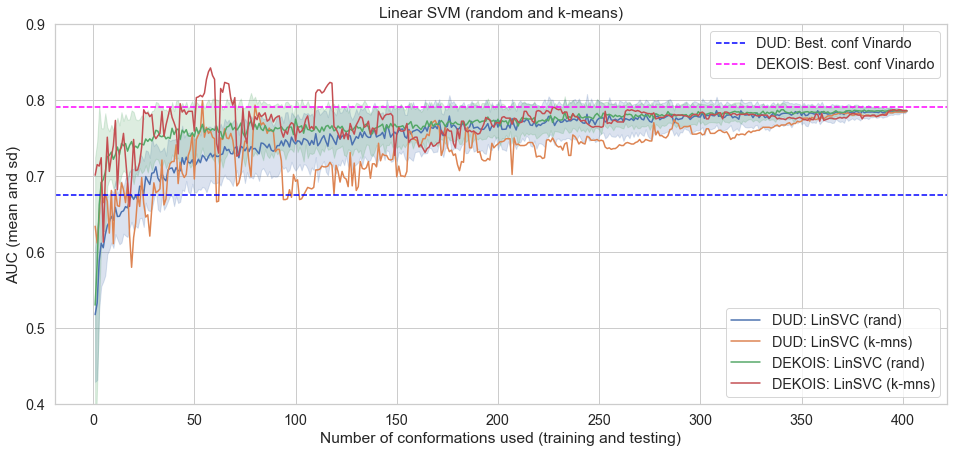

In [14]:
# Results
fig, ax = plt.subplots(figsize=(16, 7))
_results_dic = {'LinSVC (rand)': lSVC_rd_dict, 'LinSVC (k-mns)': lSVC_km_dict}

_plot_results(results_dic = _results_dic, test_keys = test_keys, ax = ax)
ax.set_xlabel('Number of conformations used (training and testing)')
ax.set_ylabel('AUC (mean and sd)')
ax.set_title('Linear SVM (random and k-means)')
plt.show()

## Radial Basis Function SVM
<div style='background-color: #F9E5AB; min-height: 10px'></div>

#### Random picking

In [15]:
ml_model = SVC
model_name = 'rbfSVC'
# hyperparameters
hyparms = dict(kernel = 'rbf', probability = True, gamma = 0.001, C = 10)

rbfSVC_rd_dict = random_picking_ML(ml_model, model_name, scores_dic, train_key, test_keys, n_reps = 30,
                  **hyparms)

#### K-means picking

In [16]:
ml_model = SVC
model_name = 'rbfSVC'
# hyperparameters
hyparms = dict(kernel = 'rbf', probability = True, gamma = 0.001, C = 10)

rbfSVC_km_dict =  kmeans_picking_ML(ml_model, model_name, scores_dic, train_key, test_keys,
                  df_precomputed_medoids = df_confs_per_k,
                  **hyparms)

<h4>Visualization: <span class="text-muted">Radial Basis Function SVM</span></h4>

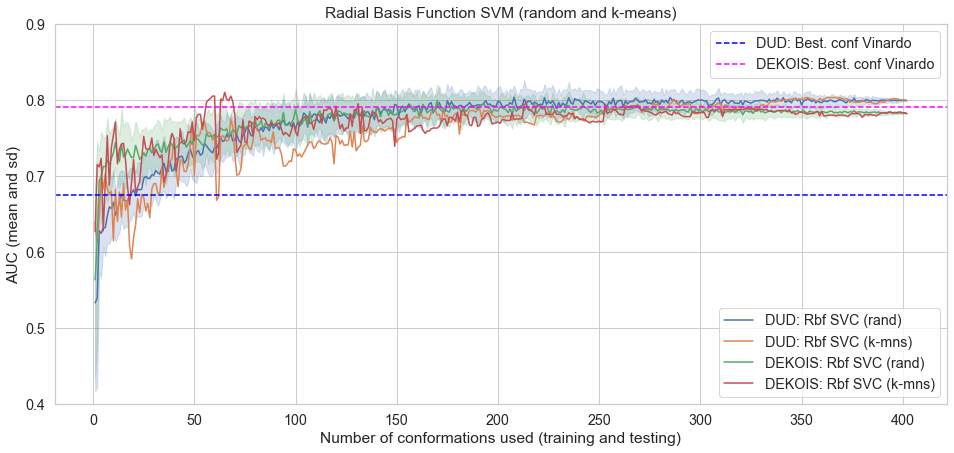

In [30]:
# Results
fig, ax = plt.subplots(figsize=(16, 7))
_results_dic = {'Rbf SVC (rand)': rbfSVC_rd_dict, 'Rbf SVC (k-mns)': rbfSVC_km_dict}

_plot_results(results_dic = _results_dic, test_keys = test_keys, ax = ax)
ax.set_xlabel('Number of conformations used (training and testing)')
ax.set_ylabel('AUC (mean and sd)')
ax.set_title('Radial Basis Function SVM (random and k-means)')
plt.show()

## Logistic Regression
<div style='background-color: #F9E5AB; min-height: 10px'></div>

In [18]:
from sklearn.linear_model import LogisticRegression

#### Random picking

In [19]:
ml_model = LogisticRegression
model_name = 'LogRg'
# hyperparameters
hyparms = dict(C = 1, penalty = 'l2', solver = 'lbfgs')

logRG_rd_dict = random_picking_ML(ml_model, model_name, scores_dic, 
                                  train_key, test_keys, n_reps = 30,
                                  **hyparms)

#### K-means picking

In [20]:
ml_model = LogisticRegression
model_name = 'LogRg'
# hyperparameters
hyparms = dict(C = 1, penalty = 'l2', solver = 'lbfgs')

logRG_km_dict =  kmeans_picking_ML(ml_model, model_name, scores_dic, train_key, test_keys,
                  df_precomputed_medoids = df_confs_per_k,
                  **hyparms)

<h4>Visualization: <span class="text-muted">Logistic Regression</span></h4>

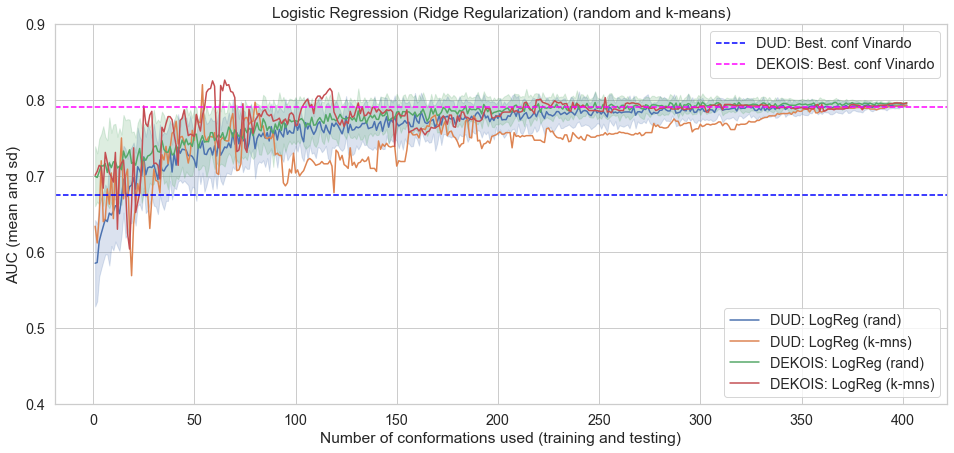

In [21]:
# Results
fig, ax = plt.subplots(figsize=(16, 7))
_results_dic = {'LogReg (rand)': logRG_rd_dict, 'LogReg (k-mns)': logRG_km_dict}

_plot_results(results_dic = _results_dic, test_keys = test_keys, ax = ax)
ax.set_xlabel('Number of conformations used (training and testing)')
ax.set_ylabel('AUC (mean and sd)')
ax.set_title('Logistic Regression (Ridge Regularization) (random and k-means)')
plt.show()

## Decision Tree Classifier
<div style='background-color: #F9E5AB; min-height: 10px'></div>

In [22]:
from sklearn.tree import DecisionTreeClassifier

In [23]:
%%time
ml_model = DecisionTreeClassifier
model_name = 'Tree'
# hyperparameters
hyparms = dict(criterion = 'gini', max_depth = 2)

dTree_rd_dict = random_picking_ML(ml_model, model_name, scores_dic, 
                                  train_key, test_keys, n_reps = 30,
                                  **hyparms)

CPU times: user 1.59 ms, sys: 309 µs, total: 1.9 ms
Wall time: 1.21 ms


In [24]:
%%time
ml_model = DecisionTreeClassifier
model_name = 'Tree'
# hyperparameters
hyparms = dict(criterion = 'gini', max_depth = 2)

dTree_km_dict =  kmeans_picking_ML(ml_model, model_name, scores_dic, train_key, test_keys,
                  df_precomputed_medoids = df_confs_per_k,
                  **hyparms)

CPU times: user 986 µs, sys: 193 µs, total: 1.18 ms
Wall time: 711 µs


<h4>Visualization: <span class="text-muted">Decision Tree Classifier</span></h4>

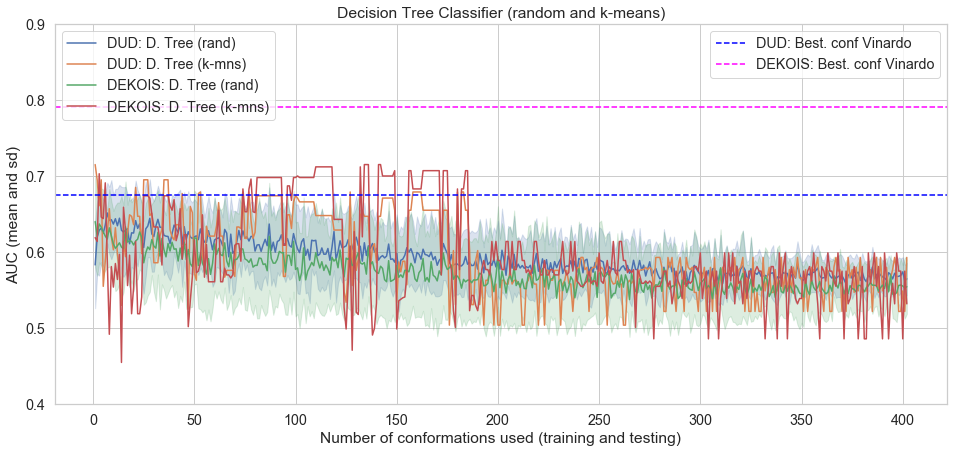

In [25]:
# Results
fig, ax = plt.subplots(figsize=(16, 7))
_results_dic = {'D. Tree (rand)': dTree_rd_dict, 'D. Tree (k-mns)': dTree_km_dict}

_plot_results(results_dic = _results_dic, test_keys = test_keys, ax = ax, legend_position = 'upper left')
ax.set_xlabel('Number of conformations used (training and testing)')
ax.set_ylabel('AUC (mean and sd)')
ax.set_title('Decision Tree Classifier (random and k-means)')
plt.show()

## Dummy Classifier
<div style='background-color: #F9E5AB; min-height: 10px'></div>

In [26]:
from sklearn.dummy import DummyClassifier

#### K-means picking

In [27]:
ml_model = DummyClassifier
model_name = 'DummyStf'
# hyperparameters
hyparms = dict(strategy = 'stratified')

DummyStf_km_dict =  kmeans_picking_ML(ml_model, model_name, scores_dic, train_key, test_keys,
                  df_precomputed_medoids = df_confs_per_k,
                  **hyparms)

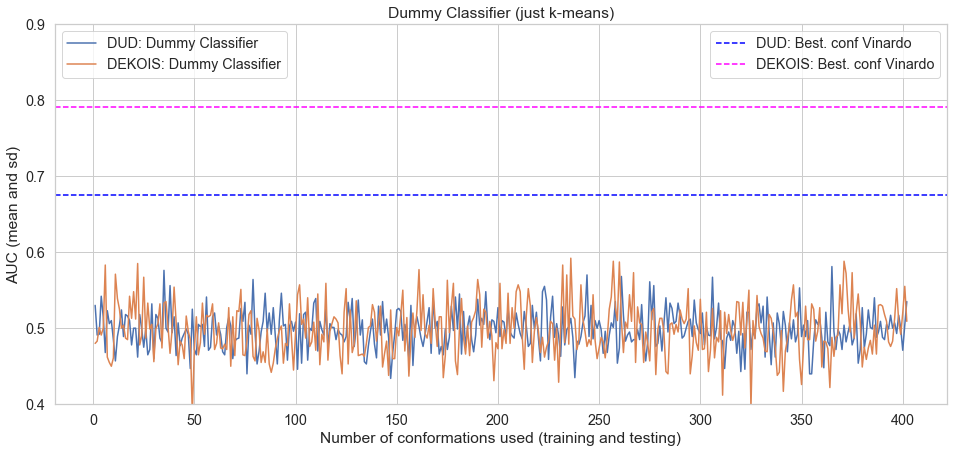

In [28]:
# Results
fig, ax = plt.subplots(figsize=(16, 7))
_results_dic = {'Dummy Classifier': DummyStf_km_dict}

_plot_results(results_dic = _results_dic, test_keys = test_keys, ax = ax, legend_position = 'upper left')
ax.set_xlabel('Number of conformations used (training and testing)')
ax.set_ylabel('AUC (mean and sd)')
ax.set_title('Dummy Classifier (just k-means)')
plt.show()